## Eval architecture choices

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%autoreload

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp
from natsort import natsorted
from uloss_wmh.fitting.fitter import StandardLitModelWrapper
from uloss_wmh.fitting.optimizer_constructor import OptimizerConfigurator, standard_configurations
from tqdm import tqdm

In [4]:
from uloss_wmh.evaluate.eval_metrics.challenge_metrics import do_challenge_metrics, per_model_chal_stats

In [5]:
# loss functions
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, DiceCELoss, DiceFocalLoss
from uloss_wmh.loss_functions.brier import Brier, BrierPlusDice
from uloss_wmh.loss_functions.odyssey_dice import SoftDiceLoss, DC_and_topk_loss
from uloss_wmh.loss_functions.odyssey_ND_Crossentropy import TopKLoss, CrossentropyND
from uloss_wmh.loss_functions.dice_plusplus import DicePlusPlusLoss

### loading the train, val and test datasets in 3D this time.

In [6]:
from ulw_data.torch_dataset.challenge_dataset_3D import load_3D_wmh_chal
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [7]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=3)

In [8]:
test_dss = load_3D_wmh_chal(ds_path=collated_folder, train=False, combine=False)

In [9]:
len(test_dss)

5

In [10]:
test_dss[4][0]['uid']

'test_Utrecht_1'

In [11]:
# computing the voxel histogram for each image in the test dataset.
example = test_dss[0][0]['image'][0]

In [12]:
flat = example.view(-1)
flat = flat[flat != 0]

In [14]:
MODEL_CONFIGS = {
    "model1":smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
),
    "model2":smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
    decoder_attention_type='scse',
),
    "model3":smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
    decoder_attention_type='scse',
),
    "model4":smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=3,
    decoder_channels=[256,64,16],
),
    "model5":smp.MAnet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
),
    "model6":smp.MAnet(
    encoder_name="densenet121",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
),
    "model7":smp.Linknet(
    encoder_name="efficientnet-b1",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
),
    "model8":smp.Linknet(
    encoder_name="timm-gernet_m",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
),
    "model9":smp.Linknet(
    encoder_name="timm-res2net50_26w_4s",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,
),
    "model10":smp.PAN(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    decoder_channels=16,
),
    "model11":smp.PAN(
    encoder_name="resnext50_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
),
    "model12":smp.DeepLabV3Plus(
    encoder_name="resnext50_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
),
    "model13":smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
),
    "model14":smp.DeepLabV3Plus(
    encoder_name="timm-regnetx_016",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
),
}


In [27]:
ckpt_dir = "/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/"

In [28]:
loss_func = DiceLoss(sigmoid=True)

In [29]:
ckpts = os.listdir(ckpt_dir + ",model1")

In [30]:
natsorted(ckpts)

['epoch=67-step=8500.ckpt', 'epoch=91-step=11500.ckpt', 'lightning_logs']

In [33]:
test_dss[0][0]['image'].shape

torch.Size([3, 192, 224, 64])

In [34]:
inp = test_dss[0][0]['image'].moveaxis(-1,0)
batch0 = inp[0:8]
batch1 = inp[8:16]
batch2 = inp[16:24]
batch3 = inp[24:32]
batch4 = inp[32:40]
batch5 = inp[40:48]
batch6 = inp[48:56]
batch7 = inp[56:64]
batch_parts = [batch0, batch1, batch2, batch3, batch4, batch5, batch6, batch7]
out = torch.cat(batch_parts)
out.shape

torch.Size([64, 3, 192, 224])

In [52]:
batch0.shape

torch.Size([8, 3, 192, 224])

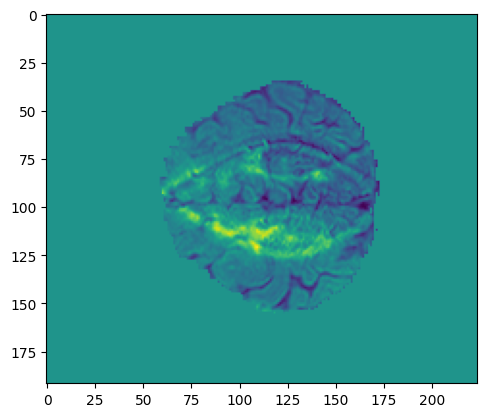

In [61]:
plt.imshow(batch5[6,0].cpu())

In [44]:
model_performances = []

for num in range(14):
    model_name = f",model{num+1}"
    ckpt = ckpt_dir + model_name + "/" + natsorted(os.listdir(ckpt_dir + model_name))[1]
    print(ckpt)

    custom_optim_config = OptimizerConfigurator(optim='Adam', lr=2e-4, weight_decay=0, scheduler=None)
    model = StandardLitModelWrapper.load_from_checkpoint(checkpoint_path=ckpt, model=MODEL_CONFIGS[model_name[1:]], loss=loss_func, optimizer_configurator=custom_optim_config)

    performance_results_per_domain = []

    with torch.no_grad():
        for dataset in test_dss:

            preds = []
            labels = []
            for data in tqdm(dataset, position=0, leave=True):
                inp = data['image'].cuda().moveaxis(-1,0)
                labels.append(data['label'].squeeze())
                batch0 = inp[0:8]
                batch1 = inp[8:16]
                batch2 = inp[16:24]
                batch3 = inp[24:32]
                batch4 = inp[32:40]
                batch5 = inp[40:48]
                batch6 = inp[48:56]
                batch7 = inp[56:64]
                batch_parts = [batch0, batch1, batch2, batch3, batch4, batch5, batch6, batch7]
                outs = []
                for batch_i in batch_parts:
                    out = model.cuda()(batch_i)
                    out = torch.sigmoid(out).squeeze() > 0.5
                    out = out.moveaxis(0, -1)
                    outs.append(out.cpu())
                    #print(out.shape)
                preds.append(torch.cat(outs, dim=-1))
                #print(preds[-1].shape)

            performance_data = per_model_chal_stats(preds, labels, do_argmax=False)
            performance_results_per_domain.append(performance_data)
    model_performances.append(performance_results_per_domain)

/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model1/epoch=91-step=11500.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model2/epoch=148-step=18625.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model3/epoch=58-step=7375.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model4/epoch=106-step=13375.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model5/epoch=35-step=4500.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model6/epoch=1-step=250.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:33<00:00,  3.11s/it]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model7/epoch=171-step=21500.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model8/epoch=166-step=20875.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.33it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model9/epoch=106-step=13375.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.31it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model10/epoch=104-step=13125.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model11/epoch=113-step=14250.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.36it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model12/epoch=74-step=9375.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model13/epoch=104-step=13125.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


/media/benp/NVMEspare/project_data/loss_func_proj/models/architecture_dice_models/,model14/epoch=90-step=11375.ckpt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


In [46]:
df = {"model_name":[], "dice":[], "hd95":[], "avd":[], "recall":[], "f1":[]}
for i, data in enumerate(model_performances):
    model_name = f"model{i+1}"
    dice = []
    f1 = []
    avd = []
    hd95 = []
    recall = []
    for dd in data:
        dice.extend(dd['dice'].tolist())
        hd95.extend(dd['hd95'].tolist())
        avd.extend(dd['avd'].tolist())
        recall.extend(dd['recall'].tolist())
        f1.extend(dd['f1'].tolist())
    df['dice'].extend(dice)
    df['f1'].extend(f1)
    df['avd'].extend(avd)
    df['hd95'].extend(hd95)
    df['recall'].extend(recall)
    df['model_name'].extend([model_name for _ in range(len(dice))])

<Axes: >

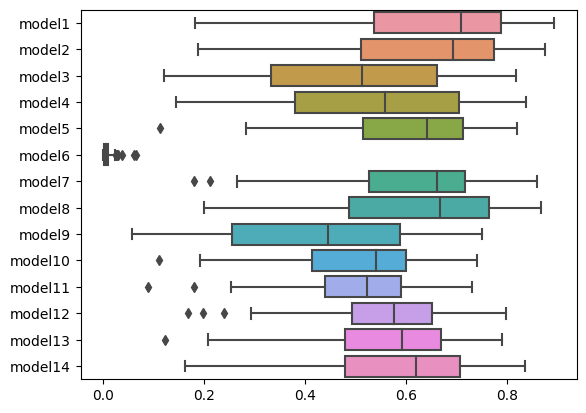

In [47]:
sns.boxplot(data=df, y="model_name", x="dice")

<Axes: >

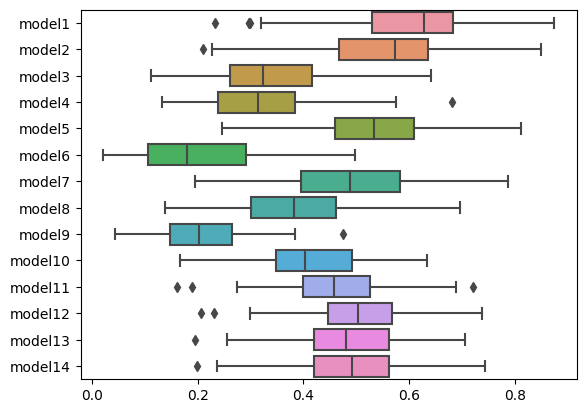

In [48]:
sns.boxplot(data=df, y="model_name", x="f1")

<Axes: >

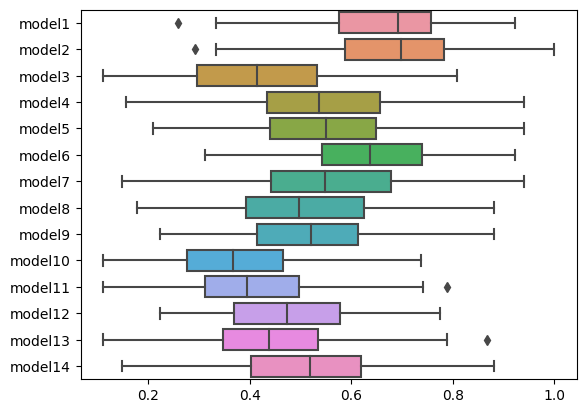

In [49]:
sns.boxplot(data=df, y="model_name", x="recall")

<Axes: >

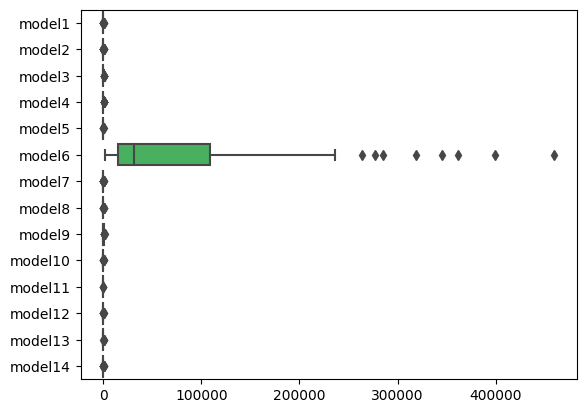

In [50]:
sns.boxplot(data=df, y="model_name", x="avd")

<Axes: >

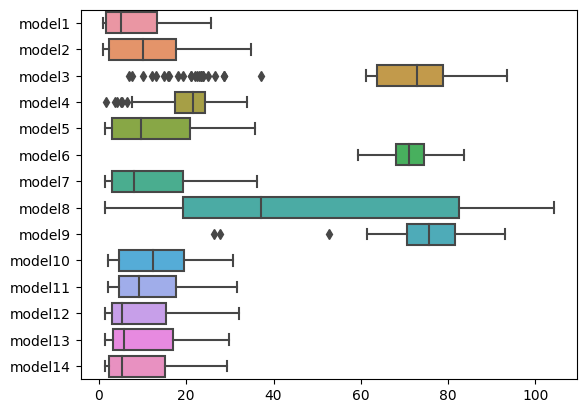

In [51]:
sns.boxplot(data=df, y="model_name", x="hd95")

In [62]:
def weighted_challenge_metrics(model_performances_per_domain):
    lengths = []
    mean_dices = []
    mean_f1s = []
    mean_avds = []
    mean_hd95s = []
    mean_recalls = []
    for data in model_performances_per_domain:
        lengths.append(len(data['dice'].tolist()))
        mean_dices.append(data['dice'].mean().item())
        mean_f1s.append(data['f1'].mean().item())
        mean_avds.append(data['avd'].mean().item())
        mean_hd95s.append(data['hd95'].mean().item())
        mean_recalls.append(data['recall'].mean().item())
        
    mean_dices = [m * lengths[i] for (i, m) in enumerate(mean_dices)]
    mean_f1s = [m * lengths[i] for (i, m) in enumerate(mean_f1s)]
    mean_avds = [m * lengths[i] for (i, m) in enumerate(mean_avds)]
    mean_hd95s = [m * lengths[i] for (i, m) in enumerate(mean_hd95s)]
    mean_recalls = [m * lengths[i] for (i, m) in enumerate(mean_recalls)]
    
    total = torch.Tensor(lengths).sum()
    
    return (
        torch.Tensor(mean_dices).sum() / total,
        torch.Tensor(mean_f1s).sum() / total,
        torch.Tensor(mean_avds).sum() / total,
        torch.Tensor(mean_hd95s).sum() / total,
        torch.Tensor(mean_recalls).sum() / total,
    )
        

In [63]:
for i, data in enumerate(model_performances):
    model_name = f"model{i+1}"
    weighted_means = weighted_challenge_metrics(data)
    print(model_name, weighted_means)

model1 (tensor(0.6624), tensor(0.5967), tensor(55.3995), tensor(7.9061), tensor(0.6626))
model2 (tensor(0.6397), tensor(0.5436), tensor(60.4374), tensor(11.3635), tensor(0.6796))
model3 (tensor(0.4884), tensor(0.3337), tensor(151.0071), tensor(63.2690), tensor(0.4156))
model4 (tensor(0.5361), tensor(0.3205), tensor(131.6427), tensor(20.4263), tensor(0.5431))
model5 (tensor(0.6068), tensor(0.5269), tensor(40.9589), tensor(12.0196), tensor(0.5419))
model6 (tensor(0.0085), tensor(0.1973), tensor(75423.4453), tensor(71.5210), tensor(0.6324))
model7 (tensor(0.6126), tensor(0.4848), tensor(54.9851), tensor(11.4257), tensor(0.5539))
model8 (tensor(0.6149), tensor(0.3841), tensor(61.0046), tensor(46.6313), tensor(0.5046))
model9 (tensor(0.4214), tensor(0.2086), tensor(236.5851), tensor(75.1501), tensor(0.5179))
model10 (tensor(0.5070), tensor(0.4124), tensor(49.0813), tensor(12.5961), tensor(0.3741))
model11 (tensor(0.5004), tensor(0.4589), tensor(42.2379), tensor(11.2419), tensor(0.4113))
mod

### other evaluation points to compute
for each of these it would be nice to be able to separate it per domain.
once I have these I have the full set of evaluations for any MICCAI paper that I want to write....
- [ ] calculating volume
- [ ] calibration (n step)
- [ ] calibration vs volume n step
- [ ] challenge metrics vs volume
- [ ] missing instances (and their size)
- [ ] introduced instances (and their size)
- [ ] uncertainty map coverage of missing lesions
- [ ] sUEO
- [ ] BraS score
- [ ] TP, FP FN scores
- [ ] post hoc calibration
- [ ] precision / recall per segmentation theshold as in the Dice++ paper.
- [ ] sample diversity / GeD (assuming I have an ensemble model, with an Ind output channel).
- [ ] lesion coverage in 2D and 3D axial slices
- [ ] pavpu metrics